# Hough Transform Testing

In [2853]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import random

In [2854]:
# Find all normal lines from point pairs
def points2lines(points):
    lines = np.zeros([1,3])
    r,c = points.shape
    while(r>1):
        for i in np.arange(1,r):
            line = np.cross(points[0,:], points[i,:])
            lines = np.vstack([lines, line])
        points = points[1:,:]
        r,c = points.shape
    lines = lines[1:,:]
 
    return lines


# Convert linear eqn to rho-theta
def linear2hough(lines):
    rhotheta = np.zeros([lines.shape[0],2])
    for i in range(lines.shape[0]):
        slope = -lines[i,0]/lines[i,1]
        theta = math.atan(-1/slope)
        if theta !=(0):
            b = -lines[i,2]/lines[i,1]
            x = -b/(slope+1/slope)
            y = slope*x + b
            rho = x*np.cos(theta) + y*np.sin(theta)
        else:
            rho = -lines[i,2]/lines[i,0]
        rhotheta[i,:] = [rho, theta]
    return rhotheta

Create a test image of a square

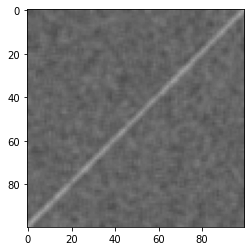

In [2855]:
# Create image with lines
r = 100
c = 100
image = 100*np.ones([r,c])
line = 155*np.eye(r)
image = np.fliplr(image+line)

# Add noise to the image
sigma = 20
mean = 0
noise = sigma*np.random.randn(r,c) + mean
image = image+noise
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Smooth the image
box = np.ones([3,3])/9
image = nd.convolve(image,box)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

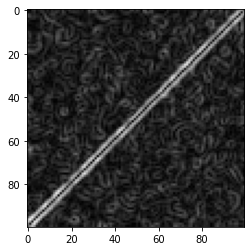

In [2856]:
# Find the edges
sobelx = np.array([[1,0,-1],
                   [2,0,-2],
                   [1,0,-1]])

sobely = np.array([[ 1, 2, 1],
                   [ 0, 0, 0],
                   [-1,-2,-1]])

Ix = nd.convolve(image,sobelx)
Iy = nd.convolve(image,sobely)
mag = np.sqrt(Ix**2+Iy**2)
plt.imshow(mag, cmap='gray', vmin=0, vmax=255)

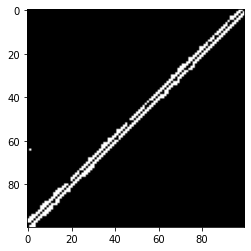

In [2857]:
# Submax supression
threshold = 0.5
mask = 1*( mag >= threshold*np.amax(mag) )
edgels = np.where(mag >= threshold*np.amax(mag))
edgels = np.array(edgels).T
plt.imshow(mask, cmap='gray')

# RANSAC
Random Sample Consensus

In [2858]:
def RANSAC(data,model,threshold):
    # probability that one sample is clean
    p = 0.99
    # probablility that point is an outlier
    e = 0.1
    # number of samples needed
    N = np.log(1-p) / np.log(1-(1-e)**model)
    N = np.int(np.round(N))

    votes = np.zeros([N,3])
    bestFit = 0

    # Add a column of 1's to the end
    r,c = data.shape
    data = np.hstack([data, np.ones([r,1])])

    i = 0
    while i < N:
        # Find two random edgels
        pair = np.random.randint(data.shape[0],size=2)

        # Insure pairs are unique
        while pair[0] == pair[1]:
            pair[1] = np.random.randint(data.shape[0])
        pair = data[pair]

        # Convert edgels to (a,b,c)
        plane = points2lines(pair)

        # Edgel distance to plane
        dist = np.abs(np.dot(data,plane.T))

        # Threshold distances
        dist = np.where(dist <= threshold)

        rhotheta = linear2hough(plane)
        rhotheta = np.concatenate(rhotheta)
        votes[i,:] = np.hstack([np.sum(dist),rhotheta])

        i += 1
    
    idx = np.where(votes[:,0] == np.amax(votes[:,0]))
    print(len(idx[0]))
    print(idx[0])
    print(votes[idx])

    return bestFit


In [2859]:
model = 2
threshold = 1
RANSAC(edgels,model,threshold)
print('Correct:',np.sqrt(2*50**2),np.pi/4)

1
[2]
[[2.01400000e+04 7.14177849e+01 7.85398163e-01]]
Correct: 70.71067811865476 0.7853981633974483
